# Imports

In [2]:
import sys
sys.path.append('/Users/iliemoromete/Desktop/GLITCH_1.21.4/__WAR__')
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from __path__ import *

import os
print(os.getcwd())

PATH_NEWS = f'{PATH_GLITCH}/__WAR__/NEWS.csv'

Operating System: Darwin
PATH_ROOT: /Users/iliemoromete/Desktop
/Users/iliemoromete/Desktop/GLITCH_1.21.4/__BCKTST__


# Pivotting (for comparison sake)

Pivot signals saved to /Users/iliemoromete/Desktop/GLITCH_REBORN/__BCKTST__/bcktst_PIVOTS.csv


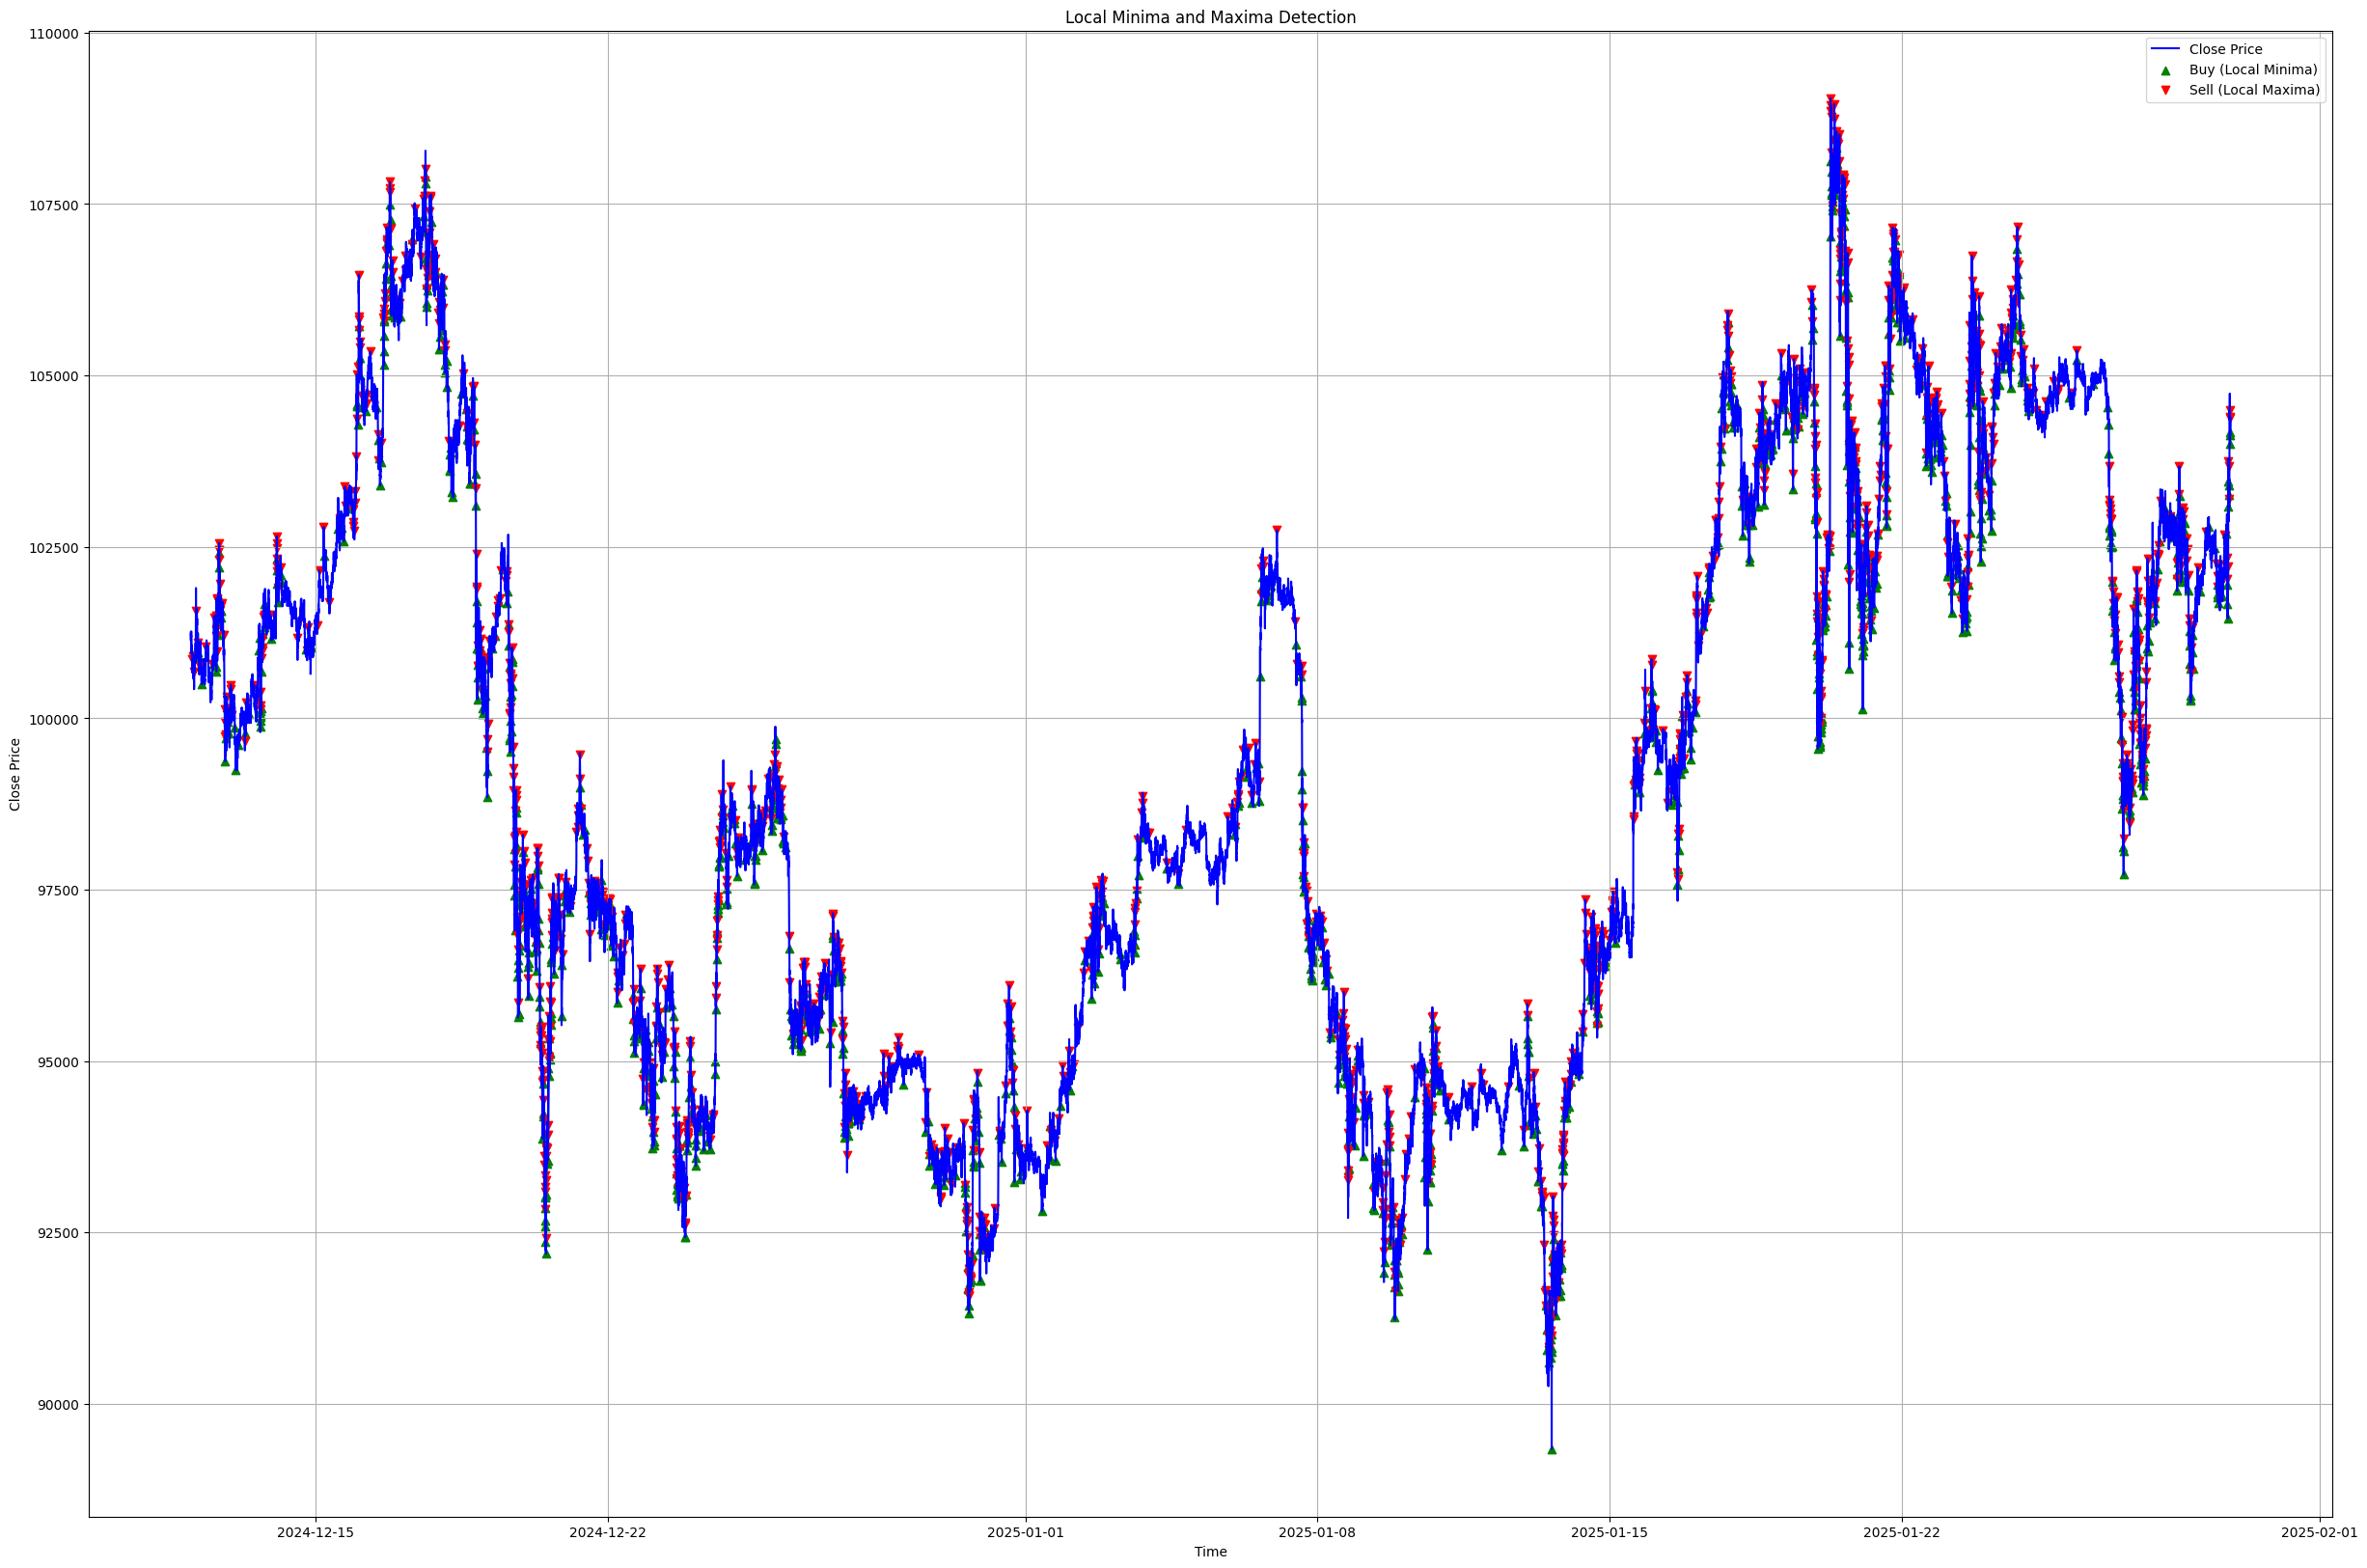

In [3]:
klines_file = f'{PATH_GLITCH}/__BCKTST__/bcktst.csv'
klines_df = pd.read_csv(klines_file)

class Pivot:
    def __init__(self, df, interval, window_size=5, significance_threshold=0.001):
        """
        Initialize the pivot detection algorithm.

        Parameters:
        - df: DataFrame containing price data with 'timestamp' and 'close' columns.
        - interval: The time interval (e.g., '1m', '15m', etc.).
        - window_size: Number of surrounding values to check for local extrema.
        - significance_threshold: Minimum relative change to consider as a pivot point.
        """
        self.df = df.copy()
        self.interval = interval
        self.window_size = window_size
        self.significance_threshold = significance_threshold
        self.pivots = None
        self.signals = None
        self.df['timestamp'] = pd.to_datetime(self.df['timestamp'])
        self.df['pivot'] = np.nan
        self.df['pivot'] = self.df['pivot'].astype('object')

    def detect_pivots(self):
        self.df['pivot'] = None
        self.df['pivot'] = self.df['pivot'].astype('object')
        self.df['price_change'] = self.df['close'].pct_change().abs()
        self.df['local_min'] = self.df['close'].rolling(window=self.window_size, center=True).apply(
            lambda x: x[self.window_size // 2] if x[self.window_size // 2] == np.min(x) else np.nan,
            raw=True
        )
        self.df['local_max'] = self.df['close'].rolling(window=self.window_size, center=True).apply(
            lambda x: x[self.window_size // 2] if x[self.window_size // 2] == np.max(x) else np.nan,
            raw=True
        )

        def classify_pivot(row):
            if pd.notna(row['local_min']) and row['price_change'] > self.significance_threshold:
                return 'min'
            elif pd.notna(row['local_max']) and row['price_change'] > self.significance_threshold:
                return 'max'
            return None
        self.df['pivot'] = self.df.apply(classify_pivot, axis=1)
        self.pivots = self.df.dropna(subset=['pivot'])

    def generate_signals(self):
        """Generate buy/sell signals based on pivot points."""
        self.signals = []
        last_signal = None
        for idx, row in self.pivots.iterrows():
            if row['pivot'] == 'min' and last_signal != 'buy':
                self.signals.append((row['timestamp'], row['close'], "buy"))
                last_signal = "buy"
            elif row['pivot'] == 'max' and last_signal != 'sell':
                self.signals.append((row['timestamp'], row['close'], "sell"))
                last_signal = "sell"
            else:
                self.signals.append((row['timestamp'], row['close'], "hold"))

    def save_to_csv(self):
        """Save the signals to a CSV file."""
        output_path = f'{PATH_ROOT}/GLITCH_REBORN/__BCKTST__/bcktst_PIVOTS.csv'
        signals_df = pd.DataFrame(self.signals, columns=['timestamp', 'price', 'signal'])
        signals_df.to_csv(output_path, index=False)
        print(f"Pivot signals saved to {output_path}")

    def plot_signals(self):
        """Plot price data along with detected buy/sell signals."""
        plt.figure(figsize=(30, 20))
        plt.plot(self.df['timestamp'], self.df['close'], label="Close Price", color="blue")

        buy_signals = self.df[self.df['pivot'] == 'min']
        sell_signals = self.df[self.df['pivot'] == 'max']

        plt.scatter(buy_signals['timestamp'], buy_signals['close'], color='green', label='Buy (Local Minima)', marker='^')
        plt.scatter(sell_signals['timestamp'], sell_signals['close'], color='red', label='Sell (Local Maxima)', marker='v')

        plt.title("Local Minima and Maxima Detection")
        plt.xlabel("Time")
        plt.ylabel("Close Price")
        plt.legend()
        plt.grid(True)
        plt.show()

    def run(self):
        """Run the full pipeline."""
        self.detect_pivots()
        self.generate_signals()
        self.save_to_csv()
        self.plot_signals()

pivot_detector = Pivot(klines_df, interval='1m', window_size=5, significance_threshold=0.001)
pivot_detector.run()

# BCKTST
### Historical pivots


Loaded 3187 rows from /Users/iliemoromete/Desktop/GLITCH_REBORN/__BCKTST__/bcktst_PIVOTS.csv


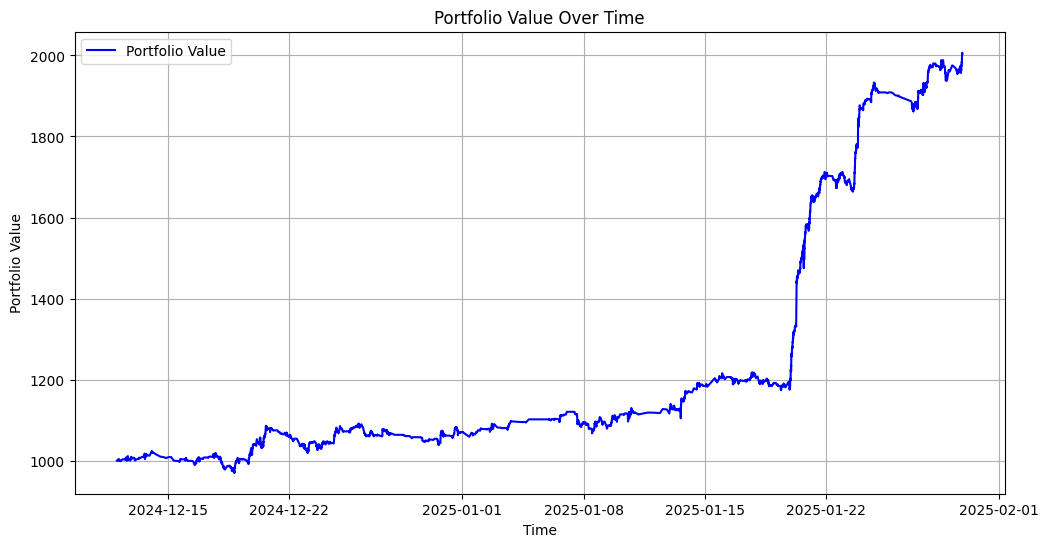

Final Portfolio Value: $2004.70
Total Return: 100.47%


In [4]:
from _BCKTST import BCKTST_historical
file_path = f'{PATH_GLITCH}/__BCKTST__/bcktst_PIVOTS.csv'
backtest = BCKTST_historical(file_path)
backtest.run()

# Delta T (from Pivot system)

In [5]:
input_path = f'{PATH_GLITCH}/__BCKTST__/bcktst_PIVOTS.csv'
output_path = f'{PATH_GLITCH}/__BCKTST__/bcktst_PERIODS_1m.csv'

class deltaTextractor:
    def __init__(self, input_file, output_file):
        """
        Initialize the PivotPeriodAnalyzer with input and output file paths.
        
        Args:
        - input_file (str): Path to the PIVOTS_1m.csv file.
        - output_file (str): Path to save the calculated pivot periods.
        """
        self.input_file = input_file
        self.output_file = output_file
        self.df = None
        self.periods = []

    def load_data(self):
        """Loads the CSV file and parses the timestamp column."""
        try:
            self.df = pd.read_csv(self.input_file, parse_dates=['timestamp'])
            print(f"Successfully loaded data from {self.input_file}")
        except FileNotFoundError:
            print(f"Error: The file {self.input_file} was not found.")
            self.df = None

    def calculate_periods(self):
        """Calculates the time difference between consecutive buy/sell signals."""
        if self.df is None:
            print("Data not loaded. Please check the file path.")
            return   
        buy_time = None
        for index, row in self.df.iterrows():
            if row['signal'] == 'buy':
                buy_time = row['timestamp']
            elif row['signal'] == 'sell' and buy_time is not None:
                sell_time = row['timestamp']
                period = (sell_time - buy_time).total_seconds() / 60  # Convert to minutes
                self.periods.append({
                    'index': len(self.periods),
                    'buy_time': buy_time,
                    'sell_time': sell_time,
                    'period_minutes': period
                })
                buy_time = None  # Reset buy time
        print(f"Calculated {len(self.periods)} periods.")

    def save_periods_to_csv(self):
        """Saves the calculated periods to the output CSV file."""
        if not self.periods:
            print("No periods calculated. Run 'calculate_periods()' first.")
            return
        periods_df = pd.DataFrame(self.periods)
        periods_df.to_csv(self.output_file, index=False)
        print(f"Periods saved successfully to {self.output_file}")

    def run(self):
        """Executes the entire process: loading data, calculating periods, and saving to CSV."""
        self.load_data()
        self.calculate_periods()
        self.save_periods_to_csv()
        return pd.DataFrame(self.periods)

analyzer = deltaTextractor(input_path, output_path)
periods_df = analyzer.run()

Successfully loaded data from /Users/iliemoromete/Desktop/GLITCH_REBORN/__BCKTST__/bcktst_PIVOTS.csv
Calculated 933 periods.
Periods saved successfully to /Users/iliemoromete/Desktop/GLITCH_REBORN/__BCKTST__/bcktst_PERIODS_1m.csv


# BCKTST
### Estimated News Pivots

# NEWS IMPACT calculator

In [6]:
import sys
sys.path.append(f'{PATH_WAR}/class/_impact.py')
sys.path.append(f'{PATH_CLASS}')

class Impactor:
    def __init__(self, input_file, output_file):
        """
        Initialize the Impactor class with input and output file paths.
        """
        self.input_file = input_file
        self.output_file = output_file
        self.df = None

    def load_data(self):
        """Loads the news data from the CSV file."""
        try:
            self.df = pd.read_csv(self.input_file, parse_dates=['published_at'])
            print(f"Successfully loaded data from {self.input_file}")
        except FileNotFoundError:
            print(f"Error: The file {self.input_file} was not found.")

    def calculate_impact(self, decay_factor=0.01):
        """
        Calculate news impact, insignificance timestamp, and period in minutes.

        Args:
        - decay_factor (float): Rate of decay for news impact.

        Returns:
        - pd.DataFrame: DataFrame containing assessed_news_headline_id, impact, 
                        news_headline_publication_timestamp, insignificance_timestamp, period_minutes.
        """
        EPSILON = 1e-6
        impact_data = []
        for _, row in self.df.iterrows():
            safe_initial_impact = max(row['importance_score'], EPSILON)
            assessed_id = row['title'][:15]  # First 15 characters of the title
            publication_time = row['published_at']

            # Calculate the insignificance timestamp (when impact falls below 10)
            time_to_insignificance = int(np.log(10 / safe_initial_impact) / -decay_factor)
            insignificance_time = publication_time + pd.Timedelta(minutes=time_to_insignificance)

            # Calculate the period in minutes
            period_minutes = (insignificance_time - publication_time).total_seconds() / 60

            impact_data.append({
                'assessed_news_headline_id': assessed_id,
                'impact': safe_initial_impact,
                'news_headline_publication_timestamp': publication_time,
                'insignificance_timestamp': insignificance_time,
                'period_minutes': period_minutes
            })
        return pd.DataFrame(impact_data)

    def remove_low_impact(self, impact_df):
        """Removes rows where the impact is below 10."""
        impact_df = impact_df[impact_df['impact'] >= 10]
        return impact_df

    def save_impact_to_csv(self, impact_df):
        """Saves the calculated impact data to the output CSV file."""
        impact_df.to_csv(self.output_file, index=False)
        print(f"Impact data saved to {self.output_file}")

    def run(self):
        """Executes the full pipeline: loading data, calculating impact, filtering, and saving."""
        self.load_data()
        impact_df = self.calculate_impact()
        impact_df = self.remove_low_impact(impact_df)
        self.save_impact_to_csv(impact_df)
        return impact_df

#####################################################################################################
input_file = f"{PATH_WAR}/NEWS.csv"
output_file = f"{PATH_WAR}/csv/NEWS_IMPACT.csv"

impactor = Impactor(input_file, output_file)
impact_df = impactor.run()
print(impact_df.head())



Successfully loaded data from /Users/iliemoromete/Desktop/GLITCH_REBORN/__WAR__/NEWS.csv
Impact data saved to /Users/iliemoromete/Desktop/GLITCH_REBORN/__WAR__/csv/NEWS_IMPACT.csv
    assessed_news_headline_id  impact news_headline_publication_timestamp  \
128                     925.0   10.70           2024-02-09 12:00:00+00:00   
169                     950.0   11.01           2024-02-14 12:00:00+00:00   
184                     875.0   10.08           2024-02-16 12:00:00+00:00   
270                     869.0   10.01           2024-02-27 06:00:00+00:00   
288                     992.0   11.53           2024-02-29 12:00:00+00:00   

     insignificance_timestamp  period_minutes  
128 2024-02-09 12:06:00+00:00             6.0  
169 2024-02-14 12:09:00+00:00             9.0  
184 2024-02-16 12:00:00+00:00             0.0  
270 2024-02-27 06:00:00+00:00             0.0  
288 2024-02-29 12:14:00+00:00            14.0  


# MODEL Trainer

In [ ]:
#####################################################################################################
from _RL import HarveySpecter
from stable_baselines3 import PPO, SAC

env = HarveySpecter()
model = PPO("MlpPolicy", env, learning_rate=0.0001, verbose=1)
model.learn(total_timesteps=100000)
model.save("trend_prediction_model")
model.load("trend_prediction_model")

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.21e+03 |
|    ep_rew_mean     | 8.27e+04 |
| time/              |          |
|    fps             | 104      |
|    iterations      | 1        |
|    time_elapsed    | 19       |
|    total_timesteps | 2048     |
---------------------------------
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 1.75e+03      |
|    ep_rew_mean          | 1.14e+05      |
| time/                   |               |
|    fps                  | 102           |
|    iterations           | 2             |
|    time_elapsed         | 40            |
|    total_timesteps      | 4096          |
| train/                  |               |
|    approx_kl            | 4.8033253e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2       

# Preparing Data for Adjustment

In [7]:
#####################################################################################################
PATH_PIVOT_PERIODS = f'{PATH_WAR}/csv/PIVOT_PERIODS_1m.csv'
PATH_NEWS_IMPACT = f'{PATH_WAR}/csv/NEWS_IMPACT.csv'

# Load data with timestamp parsing
pivot_df = pd.read_csv(PATH_PIVOT_PERIODS, parse_dates=['buy_time', 'sell_time'])
news_df = pd.read_csv(PATH_NEWS_IMPACT, parse_dates=['news_headline_publication_timestamp', 'insignificance_timestamp'])

# Remove timezone information for compatibility
pivot_df['buy_time'] = pivot_df['buy_time'].dt.tz_localize(None)
pivot_df['sell_time'] = pivot_df['sell_time'].dt.tz_localize(None)
news_df['news_headline_publication_timestamp'] = news_df['news_headline_publication_timestamp'].dt.tz_localize(None)
news_df['insignificance_timestamp'] = news_df['insignificance_timestamp'].dt.tz_localize(None)

In [8]:
from datetime import timedelta

def adjust_news_impact_with_model(model):
    adjusted_news = []
    for _, row in news_df.iterrows():
        state = np.array([
            row['impact'] / 100,  # Normalize impact
            0.5,  # Placeholder time difference ratio
            0.5  # Placeholder normalized period
        ], dtype=np.float32)
        action, _ = model.predict(state)
        new_impact = max(0, row['impact'] + action[0])  # Ensure non-negative impact

        # Calculate new insignificance timestamp
        decay_factor = 0.01
        new_period_minutes = int(np.log(10 / max(new_impact, 1e-6)) / -decay_factor)
        new_insignificance_timestamp = row['news_headline_publication_timestamp'] + timedelta(minutes=new_period_minutes)
        adjusted_news.append({
            'assessed_news_headline_id': row['assessed_news_headline_id'],
            'impact': new_impact,
            'news_headline_publication_timestamp': row['news_headline_publication_timestamp'],
            'insignificance_timestamp': new_insignificance_timestamp,
            'period_minutes': new_period_minutes  # Store the calculated period in minutes
        })
    adjusted_df = pd.DataFrame(adjusted_news)
    adjusted_df.to_csv(f'{PATH_CSV}/NEWS_PERIODS.csv', index=False)
    print("Adjusted news impact saved.")

adjust_news_impact_with_model(model)


#####################################################################################################
from _BCKTST import BCKTST_estimated
news_file = f'{PATH_GLITCH}/__WAR__/csv/NEWS_PERIODS.csv'
backtest = BCKTST_estimated(news_file, f"{PATH_BCKTST}/bcktst.csv")
backtest.run()

NameError: name 'model' is not defined